# Data Wrangling

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import brute
plt.style.use("seaborn")
#!pip install pandas_datareader
import pandas_datareader.data as web
import pandas_datareader as pdr

In [2]:
df=pd.read_csv('Binance_BTCUSDT_1h.csv')
df.head()

,unix,date,symbol,open,high,low,close,Volume BTC,Volume USDT,tradecount
0,1.615594e+12,2021-03-13 00:00:00,BTC/USDT,57221.72,57307.20,56756.32,56789.77,506.581322,2.888328e+07,13411.0
1,1.615590e+12,2021-03-12 23:00:00,BTC/USDT,57157.29,57500.00,57153.68,57221.72,1911.329085,1.095889e+08,80631.0
2,1.615586e+12,2021-03-12 22:00:00,BTC/USDT,56936.78,57465.38,56859.06,57157.29,2252.890204,1.288893e+08,107068.0
3,1.615583e+12,2021-03-12 21:00:00,BTC/USDT,56696.81,57170.00,56262.14,56936.78,2554.419549,1.448826e+08,123258.0
4,1.615579e+12,2021-03-12 20:00:00,BTC/USDT,56942.41,57200.00,56400.00,56696.80,3482.306734,1.973814e+08,103916.0


### Data Scraping

In [3]:
#eliminando outras colunas para ficar apenas Close
df.drop(['unix', 'symbol', 'high', 'low', 'open', 'Volume BTC', 'Volume USDT', 'tradecount'], axis=1,inplace=True)
df.head()

,date,close
0,2021-03-13 00:00:00,56789.77
1,2021-03-12 23:00:00,57221.72
2,2021-03-12 22:00:00,57157.29
3,2021-03-12 21:00:00,56936.78
4,2021-03-12 20:00:00,56696.80


In [4]:
df['date'] = pd.to_datetime(df['date'])
df['Date'] = df['date'].dt.date
df.drop(['date'], axis=1,inplace=True)
df=df.set_index('Date')
df.head()

,close
Date,
2021-03-13,56789.77
2021-03-12,57221.72
2021-03-12,57157.29
2021-03-12,56936.78
2021-03-12,56696.80


In [5]:
df.sort_values(by=['Date'], inplace=True, ascending=True)
df.head()

,close
Date,
2017-08-17,4308.83
2017-08-17,4285.08
2017-08-17,4336.80
2017-08-17,4333.55
2017-08-17,4325.23


In [6]:
#salvar um um arquivo CSV
df.to_csv("Binance1h.csv")

In [7]:
df.close.head()

Date
2017-08-17    4308.83
2017-08-17    4285.08
2017-08-17    4336.80
2017-08-17    4333.55
2017-08-17    4325.23
Name: close, dtype: float64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33931 entries, 2017-08-17 to 2021-03-13
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   close   33931 non-null  float64
dtypes: float64(1)
memory usage: 530.2+ KB


# Simple Moving Average (SMA) Optimizer

In [9]:
class SMABacktester(): # with ptc 
    ''' Class for the vectorized backtesting of SMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA_S: int
        time window in days for shorter SMA
    SMA_L: int
        time window in days for longer SMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA parameters
        
    test_strategy:
        runs the backtest for the SMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates SMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SMA parameters
    '''
    
    def __init__(self, symbol, SMA_S, SMA_L, start, end, tc):
        self.symbol = symbol
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMABacktester(symbol = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {})".format(self.symbol, self.SMA_S, self.SMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Binance1h.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA_S"] = raw["price"].rolling(self.SMA_S).mean()
        raw["SMA_L"] = raw["price"].rolling(self.SMA_L).mean()
        self.data = raw
        
    def set_parameters(self, SMA_S = None, SMA_L = None):
        ''' Updates SMA parameters and resp. time series.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {} | TC = {}".format(self.symbol, self.SMA_S, self.SMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, SMA):
        ''' Updates SMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMA: tuple
            SMA parameter tuple
        '''
        self.set_parameters(int(SMA[0]), int(SMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA1_range, SMA2_range):
        ''' Finds global maximum given the SMA parameter ranges.

        Parameters
        ==========
        SMA1_range, SMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA1_range, SMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [10]:
#recent history...MAs are short, no hystorical data
tester_S = SMABacktester("close", 50, 100, "2017-09-01", "2021-03-12", tc=0.001)
tester_S.optimize_parameters((9, 50, 1), (50, 200, 1))

(array([39., 51.]), 799.173016)

In [11]:
tester_S.results

,price,returns,SMA_S,SMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-09-03,4482.04,0.001319,4613.012564,4655.255294,-1,-0.001319,0.0,1.001320,0.998681
2017-09-03,4399.93,-0.018490,4604.229744,4646.564314,-1,0.018490,0.0,0.982976,1.017318
2017-09-03,4505.18,0.023639,4597.952564,4641.359412,-1,-0.023639,0.0,1.006490,0.993552
2017-09-03,4549.00,0.009680,4593.888462,4636.052157,-1,-0.009680,0.0,1.016280,0.983981
2017-09-03,4521.19,-0.006132,4590.158462,4630.325686,-1,0.006132,0.0,1.010067,0.990034
...,...,...,...,...,...,...,...,...,...
2021-03-12,57104.17,0.007170,56499.637436,56239.341961,1,0.007170,0.0,12.757487,810.959344
2021-03-12,56972.08,-0.002316,56487.194359,56304.453529,1,-0.002316,0.0,12.727977,809.083481
2021-03-12,56902.80,-0.001217,56470.279231,56368.280392,1,-0.001217,0.0,12.712499,808.099608


In [12]:
tester_S.test_strategy()
#few trades because there is no hystorical data.
#hystorical data is quality!!!

(799.173016,
 786.575775,
 0.0    32273
 2.0     1250
 Name: trades, dtype: int64)

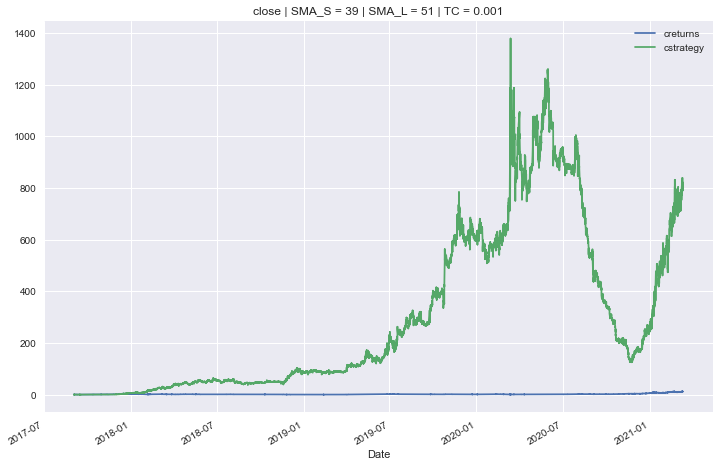

In [13]:
tester_S.plot_results()

# Exponential Moving Average (EMA) Optimizer

In [14]:
class EMABacktester(): 
    ''' Class for the vectorized backtesting of EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    EMA_S: int
        time window in days for shorter EMA
    EMA_L: int
        time window in days for longer EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new EMA parameters
        
    test_strategy:
        runs the backtest for the EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two EMA parameters
    '''
    
    def __init__(self, symbol, EMA_S, EMA_L, start, end, tc):
        self.symbol = symbol
        self.EMA_S = EMA_S
        self.EMA_L = EMA_L
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "EMABacktester(symbol = {}, EMA_S = {}, EMA_L = {}, start = {}, end = {})".format(self.symbol, self.EMA_S, self.EMA_L, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Binance1h.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["EMA_S"] = raw["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        raw["EMA_L"] = raw["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean() 
        self.data = raw
        
    def set_parameters(self, EMA_S = None, EMA_L = None):
        ''' Updates EMA parameters and resp. time series.
        '''
        if EMA_S is not None:
            self.EMA_S = EMA_S
            self.data["EMA_S"] = self.data["price"].ewm(span = self.EMA_S, min_periods = self.EMA_S).mean() 
        if EMA_L is not None:
            self.EMA_L = EMA_L
            self.data["EMA_L"] = self.data["price"].ewm(span = self.EMA_L, min_periods = self.EMA_L).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA_S"] > data["EMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | EMA_S = {} | EMA_L = {} | TC = {}".format(self.symbol, self.EMA_S, self.EMA_L, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))
        
    def update_and_run(self, EMA):
        ''' Updates EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        EMA: tuple
            EMA parameter tuple
        '''
        self.set_parameters(int(EMA[0]), int(EMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, EMA1_range, EMA2_range):
        ''' Finds global maximum given the EMA parameter ranges.

        Parameters
        ==========
        EMA1_range, EMA2_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (EMA1_range, EMA2_range), finish=None)
        return opt, -self.update_and_run(opt)

In [15]:
tester_E = EMABacktester("close", 50, 100, "2017-09-01", "2021-03-12", tc=0.001)
tester_E.optimize_parameters((9, 50, 1), (50, 200, 1))

(array([ 49., 150.]), 1.18272)

In [16]:
tester_E.results

,price,returns,EMA_S,EMA_L,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-09-07,4641.13,0.004563,4477.074987,4444.824980,1,0.004563,0.0,1.004574,1.004574
2017-09-07,4670.45,0.006298,4484.825639,4448.266938,1,0.006298,0.0,1.010920,1.010920
2017-09-07,4669.81,-0.000137,4492.239386,4451.639844,1,-0.000137,0.0,1.010781,1.010781
2017-09-07,4754.21,0.017912,4502.737749,4456.237256,1,0.017912,0.0,1.029050,1.029050
2017-09-07,4710.00,-0.009343,4511.043078,4460.085559,1,-0.009343,0.0,1.019481,1.019481
...,...,...,...,...,...,...,...,...,...
2021-03-12,57104.17,0.007170,56195.683299,54003.799287,1,0.007170,0.0,12.360210,1.197765
2021-03-12,56972.08,-0.002316,56226.739167,54043.114263,1,-0.002316,0.0,12.331619,1.194995
2021-03-12,56902.80,-0.001217,56253.781600,54080.990895,1,-0.001217,0.0,12.316623,1.193542


In [17]:
tester_E.test_strategy()

(1.18272,
 -11.022234,
 0.0    33214
 2.0      210
 Name: trades, dtype: int64)

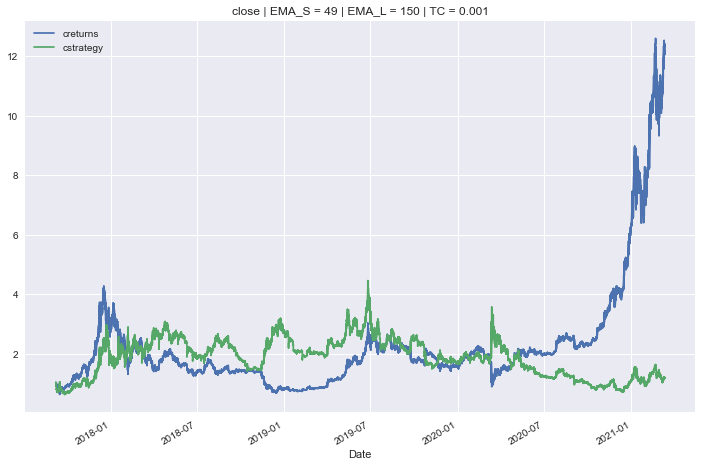

In [18]:
tester_E.plot_results()

# SMA x EMA Optimizer

In [19]:
class SMAEMABacktester(): 
    ''' Class for the vectorized backtesting of SMA/EMA-based trading strategies.

    Attributes
    ==========
    symbol: str
        ticker symbol with which to work with
    SMA: int
        time window in days for SMA
    EMA: int
        time window in days for EMA
    start: str
        start date for data retrieval
    end: str
        end date for data retrieval
    tc: float
        proportional transaction costs per trade
        
        
    Methods
    =======
    get_data:
        retrieves and prepares the data
        
    set_parameters:
        sets one or two new SMA/EMA parameters
        
    test_strategy:
        runs the backtest for the SMA/EMA-based strategy
        
    plot_results:
        plots the performance of the strategy compared to buy and hold
        
    update_and_run:
        updates EMA parameters and returns the negative absolute performance (for minimization algorithm)
        
    optimize_parameters:
        implements a brute force optimization for the two SAM/EMA parameters
    '''
    
    def __init__(self, symbol, SMA, EMA, start, end, tc):
        self.symbol = symbol
        self.SMA = SMA
        self.EMA = EMA
        self.start = start
        self.end = end
        self.tc = tc
        self.results = None 
        self.get_data()
        
    def __repr__(self):
        return "SMAEMABacktester(symbol = {}, SMA = {}, EMA = {}, start = {}, end = {})".format(self.symbol, self.SMA, self.EMA, self.start, self.end)
        
    def get_data(self):
        ''' Retrieves and prepares the data.
        '''
        raw = pd.read_csv("Binance1h.csv", parse_dates = ["Date"], index_col = "Date")
        raw = raw[self.symbol].to_frame().dropna()
        raw = raw.loc[self.start:self.end]
        raw.rename(columns={self.symbol: "price"}, inplace=True)
        raw["returns"] = np.log(raw / raw.shift(1))
        raw["SMA"] = raw["price"].rolling(self.SMA).mean() 
        raw["EMA"] = raw["price"].ewm(span = self.EMA, min_periods = self.EMA).mean() 
        self.data = raw
        
    def set_parameters(self, SMA = None, EMA = None):
        ''' Updates SMA/EMA parameters and resp. time series.
        '''
        if SMA is not None:
            self.SMA = SMA
            self.data["SMA"] = self.data["price"].rolling(self.SMA).mean() 
        if EMA is not None:
            self.EMA = EMA
            self.data["EMA"] = self.data["price"].ewm(span = self.EMA, min_periods = self.EMA).mean()
            
    def test_strategy(self):
        ''' Backtests the trading strategy.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["EMA"] > data["SMA"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # determine when a trade takes place
        data["trades"] = data.position.diff().fillna(0).abs()
        trades=data.trades.value_counts()
        
        # subtract transaction costs from return when trade takes place
        data.strategy = data.strategy - data.trades * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)
        self.results = data
        
        perf = data["cstrategy"].iloc[-1] # absolute performance of the strategy
        outperf = perf - data["creturns"].iloc[-1] # out-/underperformance of strategy
        return round(perf, 6), round(outperf, 6), trades
    
    def plot_results(self):
        ''' Plots the cumulative performance of the trading strategy
        compared to buy and hold.
        '''
        if self.results is None:
            print("No results to plot yet. Run a strategy.")
        else:
            title = "{} | SMA = {} | EMA = {} | TC = {}".format(self.symbol, self.SMA, self.EMA, self.tc)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(20, 10))
        
    def update_and_run(self, SMAEMA):
        ''' Updates SMA/EMA parameters and returns the negative absolute performance (for minimization algorithm).

        Parameters
        ==========
        SMAEMA: tuple
            SMA/EMA parameter tuple
        '''
        self.set_parameters(int(SMAEMA[0]), int(SMAEMA[1]))
        return -self.test_strategy()[0]
    
    def optimize_parameters(self, SMA_range, EMA_range):
        ''' Finds global maximum given the SMA/EMA parameter ranges.

        Parameters
        ==========
        SMA_range, EMA_range: tuple
            tuples of the form (start, end, step size)
        '''
        opt = brute(self.update_and_run, (SMA_range, EMA_range), finish=None)
        return opt, -self.update_and_run(opt)

In [20]:
tester_SE = SMAEMABacktester("close", 20, 20, "2017-09-01", "2021-03-12", tc=0.001)
tester_SE.optimize_parameters((9, 100, 1), (9, 100, 1))

(array([ 9., 27.]), 8.875587130230953e+17)

In [21]:
tester_SE.results

,price,returns,SMA,EMA,position,strategy,trades,creturns,cstrategy
Date,,,,,,,,,
2017-09-02,4530.01,0.020295,4620.542222,4664.782609,1,0.020295,0.0,1.020502,1.020502e+00
2017-09-02,4472.14,-0.012857,4593.587778,4649.206473,1,-0.012857,0.0,1.007466,1.007466e+00
2017-09-02,4509.77,0.008379,4568.455556,4638.037607,1,0.008379,0.0,1.015943,1.015943e+00
2017-09-02,4618.39,0.023800,4556.610000,4636.477363,1,0.023800,0.0,1.040412,1.040412e+00
2017-09-02,4299.53,-0.071540,4509.774444,4609.931804,1,-0.071540,0.0,0.968581,9.685808e-01
...,...,...,...,...,...,...,...,...,...
2021-03-12,57104.17,0.007170,56772.997778,56581.998307,-1,-0.007170,0.0,12.864197,8.764102e+17
2021-03-12,56972.08,-0.002316,56806.462222,56609.861285,-1,0.002316,0.0,12.834440,8.784421e+17
2021-03-12,56902.80,-0.001217,56851.217778,56630.785479,-1,0.001217,0.0,12.818833,8.795117e+17


In [22]:
tester_SE.test_strategy()

(8.875587130230953e+17,
 8.875587130230953e+17,
 0.0    31624
 2.0     1923
 Name: trades, dtype: int64)

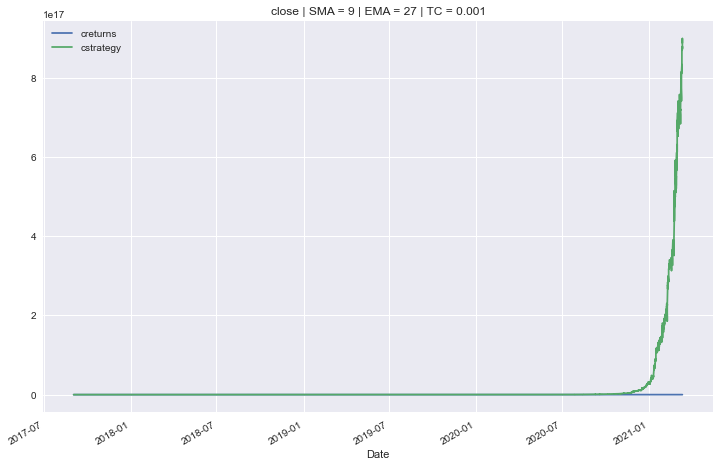

In [26]:
tester_SE.plot_results()